# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import scipy.stats as stats
import datetime as dt
import plotly.express as px
import missingno as msno
import joblib
import warnings

warnings.filterwarnings('ignore')

# **Memuat Dataset**

In [ ]:
# URL dataset UCI Machine Learning Repository
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"

# Membaca Sheet 1 (Data 2009-2010)
df_part1 = pd.read_excel(dataset_url, sheet_name='Year 2009-2010')

# Membaca Sheet 2 (Data 2010-2011)
df_part2 = pd.read_excel(dataset_url, sheet_name='Year 2010-2011')

# Menggabungkan kedua sheet menjadi satu dataset
df = pd.concat([df_part1, df_part2], ignore_index=True)

In [ ]:
# Menampilkan informasi dasar
print("\n--- Proses Selesai ---")
print(f"Total Baris Data: {df.shape[0]}")
print(f"Total Kolom Data: {df.shape[1]}")
print("\nContoh 5 data teratas:")
display(df.head())


--- Proses Selesai ---
Total Baris Data: 1067371
Total Kolom Data: 8

Contoh 5 data teratas:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [ ]:
# Menampilkan statistik deskriptif dataset
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


# **Pembersihan dan Pra Pemrosesan Data**

In [ ]:
# Missing Values & Duplicates
# Menghapus baris yang tidak memiliki Customer ID
df_clean = df.dropna(subset=['Customer ID'])

# Menghapus duplikat data jika ada
df_clean = df_clean.drop_duplicates()

print(f"Data setelah menghapus missing Customer ID dan duplikat: {df_clean.shape}")

Data setelah menghapus missing Customer ID dan duplikat: (797885, 8)


In [ ]:
# Anomali atau nilai negatif
# Memfilter hanya Quantity > 0 (Mengabaikan retur) dan Price > 0
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]

print(f"Data bersih final (Hanya transaksi valid): {df_clean.shape}")

Data bersih final (Hanya transaksi valid): (779425, 8)


In [ ]:
# Mengubah 'InvoiceDate' menjadi tipe data datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Membuat kolom 'TotalAmount' untuk perhitungan Monetary nanti
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']

# Reset index agar rapi
df_clean = df_clean.reset_index(drop=True)

# Menampilkan 5 data teratas hasil pembersihan
print("Contoh data siap olah:")
display(df_clean.head())
df_clean.info()

Contoh data siap olah:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779425 entries, 0 to 779424
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  object        
 1   StockCode    779425 non-null  object        
 2   Description  779425 non-null  object        
 3   Quantity     779425 non-null  int64         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float64       
 6   Customer ID  779425 non-null  float64       
 7   Country      779425 non-null  object        
 8   TotalAmount  779425 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 53.5+ MB


## **Perhitungan Matriks RFM**

In [ ]:
# Menentukan tanggal referensi (misalnya, satu hari setelah tanggal transaksi terakhir dalam dataset)
import datetime as dt
latest_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# Hitung nilai RFM dengan nama kolom yang benar: 'Invoice'
df_rfm = df_clean.groupby('Customer ID').agg(
    # Recency: Menghitung selisih hari antara tanggal referensi dan tanggal pembelian terakhir
    Recency=('InvoiceDate', lambda x: (latest_date - x.max()).days),
    # Frequency: Mengganti 'InvoiceNo' menjadi 'Invoice'
    Frequency=('Invoice', 'nunique'),
    # Monetary: Menghitung total 'TotalAmount'
    Monetary=('TotalAmount', 'sum')
).reset_index()

print("Hasil Matriks RFM")
display(df_rfm.head())

Hasil Matriks RFM


,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,4921.53
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


## **Pra-Pemrosesan Data RFM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Transformasi Logaritmik (mengatasi skewness)
df_rfm_log = df_rfm[['Recency', 'Frequency', 'Monetary']].copy()
df_rfm_log['Recency'] = np.log1p(df_rfm_log['Recency'])
df_rfm_log['Frequency'] = np.log1p(df_rfm_log['Frequency'])
df_rfm_log['Monetary'] = np.log1p(df_rfm_log['Monetary'])

# Scaling/Normalisasi data (MinMaxScaler)
scaler = MinMaxScaler()
df_rfm_scaled_array = scaler.fit_transform(df_rfm_log)

# Konversi kembali ke DataFrame
df_rfm_scaled = pd.DataFrame(df_rfm_scaled_array, columns=df_rfm_log.columns)
X = df_rfm_scaled

print("Data RFM Setelah Transformasi Log & Scaling")
display(df_rfm_scaled.head())

Data RFM Setelah Transformasi Log & Scaling


,Recency,Frequency,Monetary
0,0.861894,0.353449,0.830763
1,0.068566,0.284012,0.599042
2,0.615132,0.207449,0.524200
3,0.389378,0.173022,0.590176
4,0.853411,0.000000,0.373283


# **Modelling**

## Menentukan Jumlah Klaster Optimal (K)

Menentukan K Optimal dengan Metode Elbow


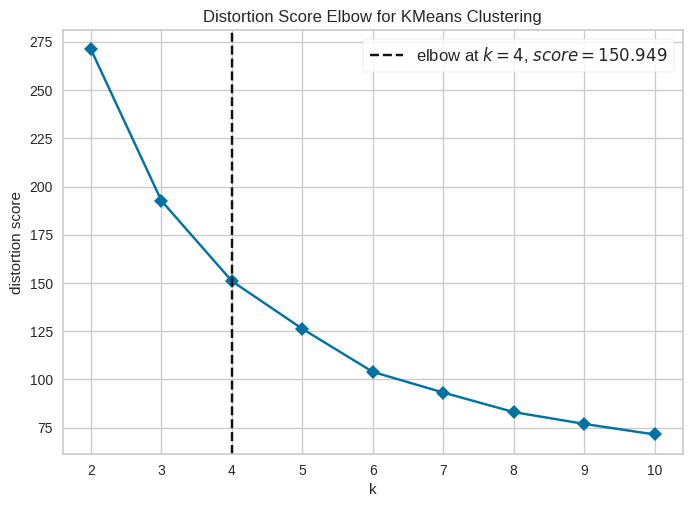

K Optimal (Elbow Method): 4


In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

# Inisialisasi model K-Means
model_kmeans = KMeans(random_state=42, n_init=10)

# Metode Elbow (Visualizer)
print("Menentukan K Optimal dengan Metode Elbow")
# Visualisasi akan membantu menentukan K.
visualizer_elbow = KElbowVisualizer(model_kmeans, k=(2, 11), metric='distortion', timings=False)
visualizer_elbow.fit(X)
visualizer_elbow.show()

optimal_k_elbow = visualizer_elbow.elbow_value_
print(f"K Optimal (Elbow Method): {optimal_k_elbow}")

# Gunakan nilai K dari Elbow untuk pemodelan akhir
K_FINAL = optimal_k_elbow

## Penerapan K-Means Clustering

In [ ]:
# Menerapkan K-Means dengan K_FINAL
kmeans_final = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
kmeans_final.fit(X)

# Menambahkan label klaster ke DataFrame RFM asli
df_rfm['Cluster'] = kmeans_final.labels_

print(f"Clustering K-Means Selesai dengan K={K_FINAL}")
display(df_rfm.sample(5))

Clustering K-Means Selesai dengan K=4


,Customer ID,Recency,Frequency,Monetary,Cluster
3100,15478.0,40,3,1983.48,3
4551,16943.0,212,5,1299.49,2
2660,15036.0,72,3,429.56,3
419,12767.0,376,1,949.82,0
3281,15659.0,44,3,532.49,3


## Menghitung silhouette_score

In [ ]:
sil_score = silhouette_score(X, kmeans_final.labels_)
print("Silhouette Score:", round(sil_score, 4))

Silhouette Score: 0.4041


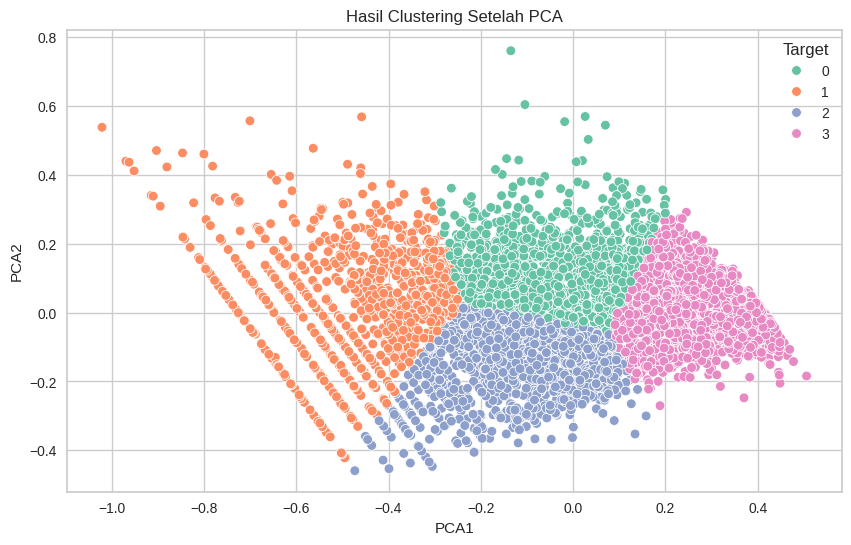

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)
data_final = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])

kmeans_pca = KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit(data_final)
data_final['Target'] = kmeans_pca.labels_

plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Target', data=data_final, palette='Set2')
plt.title('Hasil Clustering Setelah PCA')
plt.show()

## **Analisis Klaster (Profiling dan Visualisasi)**

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px

# Analisis Profil Klaster (Ulangi untuk memastikan hasil)
cluster_profile = df_rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

print("Profil Klaster RFM (Rata-Rata)")
display(cluster_profile.sort_values(by='Monetary', ascending=False))


# VISUALISASI 3D YANG DIPERBAGUS (Menggunakan data RFM yang di-Scale)

# Menggabungkan data scaled, klaster, dan data RFM asli untuk hover
df_visual = df_rfm_scaled.copy()
df_visual['Cluster'] = df_rfm['Cluster'].astype(str)
df_visual['Recency_Asli'] = df_rfm['Recency']
df_visual['Frequency_Asli'] = df_rfm['Frequency']
df_visual['Monetary_Asli'] = df_rfm['Monetary']
df_visual['Customer ID'] = df_rfm['Customer ID']


# Membuat visualisasi 3D
fig = px.scatter_3d(
    df_visual,
    # Menggunakan Recency, Frequency, Monetary yang sudah di-Scale
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    title=f'Segmentasi Pelanggan RFM dengan K-Means (K={K_FINAL})',
    height=700,
    opacity=0.8,

    # Kustomisasi Hover Data (Data yang muncul saat kursor diarahkan)
    hover_data={
        'Recency_Asli': True,
        'Frequency_Asli': True,
        'Monetary_Asli': '$.2f', # Format Monetary
        'Cluster': False,
        'Recency': False, # Sembunyikan Recency scaled dari hover
        'Frequency': False, # Sembunyikan Frequency scaled dari hover
        'Monetary': False, # Sembunyikan Monetary scaled dari hover
    },

    # Kustomisasi Label Sumbu
    labels={
        'Recency': 'Recency (Scaled/Log)',
        'Frequency': 'Frequency (Scaled/Log)',
        'Monetary': 'Monetary (Scaled/Log)',
        'Recency_Asli': 'Recency (Hari)',
        'Frequency_Asli': 'Frequency (Kali)',
        'Monetary_Asli': 'Monetary (Total $)',
    },

    # Penyesuaian tampilan (Marker size)
    symbol='Cluster',
    size_max=10
)

# Menambahkan penyesuaian tata letak (opsional)
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    scene=dict(
        xaxis_title='Recency (Scaled/Log)',
        yaxis_title='Frequency (Scaled/Log)',
        zaxis_title='Monetary (Scaled/Log)'
    )
)

fig.show()

print(" Visualisasi 3D RFM ")

Profil Klaster RFM (Rata-Rata)


,Cluster,Recency,Frequency,Monetary
1,1,10.677485,19.310345,10823.247084
2,2,117.926018,8.270989,3571.139375
3,3,36.642912,2.636782,776.989228
0,0,412.423238,1.903523,584.325098


 Visualisasi 3D RFM 


In [ ]:
df_rfm.groupby('Cluster').agg(['mean','median','min','max'])

Customer ID                                Recency                  \
                 mean   median      min      max        mean median min  max   
Cluster                                                                        
0        15347.699664  15341.0  12350.0  18286.0  412.423238  406.0  94  739   
1        15259.225152  15151.0  12347.0  18283.0   10.677485    9.0   1   43   
2        15305.889443  15329.0  12346.0  18287.0  117.926018   87.0  27  632   
3        15307.215326  15343.0  12349.0  18282.0   36.642912   30.0   1  106   

         Frequency                      Monetary                               
              mean median min  max          mean    median     min        max  
Cluster                                                                        
0         1.903523    1.0   1    9    584.325098   364.625    2.95   13916.34  
1        19.310345   12.5   2  398  10823.247084  4377.590  252.49  580987.04  
2         8.270989    7.0   1  155   3571.139375  2270.030  167.42   77556.46  
3         2.636782    2.0   1    8    776.989228   616.260    6.20    6390.36

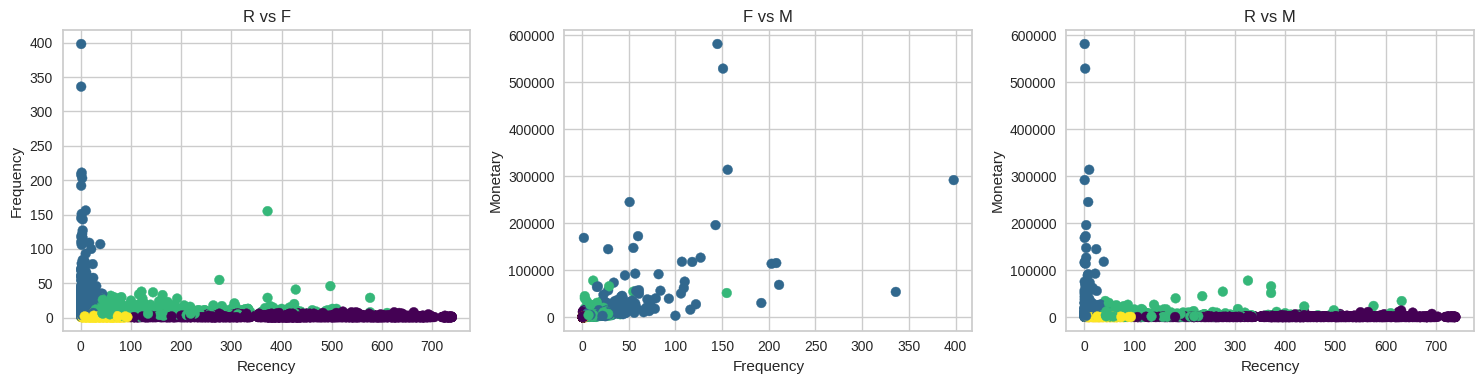

In [ ]:
plt.figure(figsize=(15, 4))

# R vs F
plt.subplot(1, 3, 1)
plt.scatter(df_rfm['Recency'], df_rfm['Frequency'], c=df_rfm['Cluster'], cmap='viridis')
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.title("R vs F")

# F vs M
plt.subplot(1, 3, 2)
plt.scatter(df_rfm['Frequency'], df_rfm['Monetary'], c=df_rfm['Cluster'], cmap='viridis')
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("F vs M")

# R vs M
plt.subplot(1, 3, 3)
plt.scatter(df_rfm['Recency'], df_rfm['Monetary'], c=df_rfm['Cluster'], cmap='viridis')
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.title("R vs M")

plt.tight_layout()
plt.show()

# **Interpretasi**



## 🟦 Cluster 0
Pelanggan hampir hilang dan kontribusi sangat kecil.

**Ciri-ciri:**
- Recency tinggi (412 hari (udah lama tidak belanja))
- Frequency rendah (1–2 kali)
- Monetary rendah (~Rp584 ribu)

**Strategi:**
- Retargeting via WhatsApp
- Tawarkan produk harga rendah

---

## 🟩 Cluster 1
Pelanggan paling loyal dan paling menguntungkan.

**Ciri-ciri:**
- Recency rendah (10 hari (baru belanja))
- Frequency tertinggi (~19 kali transaksi )
- Monetary paling besar (~Rp10.8 juta)

**Strategi:**
- Program VIP & loyalty points
- Upsell produk premium / bundling

---

## 🟧 Cluster 2
Pelanggan mulai tidak aktif, namun punya potensi tinggi.

**Ciri-ciri:**
- Recency cukup tinggi (~118 hari)
- Frequency menengah (~7–8 kali)
- Monetary menengah (~Rp3.5 juta)

**Strategi:**
- Reminder produk yang relevan
- Penawaran diskon targeted

---

## 🟨 Cluster 3
Pelanggan baru yang masih membangun hubungan dengan brand.

**Ciri-ciri:**
- Recency sedang (~36 hari)
- Frequency rendah (~2 kali)
- Monetary kecil (~Rp776 ribu)

**Strategi:**
- Welcome journey & edukasi produk
- Cross-sell produk murah
- Voucher pembelian kedua
